<a href="https://colab.research.google.com/github/o-bollverk/msf/blob/main/msf_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib.request import urlopen
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image
#from google.colab import drive
from os import listdir
import numpy as np 
import cv2
from matplotlib import image
from matplotlib import pyplot
import numpy as np
import warnings
import pandas as pd
import os 
import torch
import pandas as pd
#from fastai.vision.data import ImageDataLoaders
from fastai.vision.data import *
from fastai.vision import *
from pathlib import Path
from shutil import copyfile
import random
import shutil


Classes:

Airbus A320neo

Boeing 747-8 Intercontinental

Aviat Pitts Special S2S

Cub Crafter X Cub

Daher TBM 930

Diamond DA40NG

Diamond DA62

EXTRA 330LT



https://www.windowscentral.com/list-microsoft-flight-simulator-planes


Cloning the repository

In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/o-bollverk/msf cloned-repo
%cd cloned-repo
!ls

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo
all_data_bw			       random_selection_augmented
all_data_color			       random_selection_test
cloned-repo			       random_selection_test_mean
colab				       random_selection_test_random_hsv
convert_images.ipynb		       random_selection_test_rotate
convert_to_bw.ipynb		       random_selection_test_wrap
data_amounts			       random_selection_train
ludvig_local_msf_project1_mixed.ipynb  random_selection_train_mean
msf_data			       random_selection_train_random_hsv
msf_project1.ipynb		       random_selection_train_rotate
msf_project1_mixed.ipynb	       random_selection_train_wrap
msf_project2.ipynb		       tausta_eemaldus_gen.ipynb
nomm_cnn.ipynb			       web_data_links


In [ ]:
! git pull

Streaming output truncated to the last 5000 lines.
 .../diamond40ng/diamond da40_color_591.jpg              | Bin 0 -> 9130 bytes
 .../diamond40ng/diamond da40_color_61.jpg               | Bin 0 -> 14901 bytes
 .../diamond40ng/diamond da40_color_62.jpg               | Bin 0 -> 13831 bytes
 .../diamond40ng/diamond da40_color_625.jpg              | Bin 0 -> 11590 bytes
 .../diamond40ng/diamond da40_color_630.jpg              | Bin 0 -> 13511 bytes
 .../diamond40ng/diamond da40_color_661.jpg              | Bin 0 -> 15698 bytes
 .../diamond40ng/diamond da40_color_666.jpg              | Bin 0 -> 14779 bytes
 .../diamond40ng/diamond da40_color_667.jpg              | Bin 0 -> 17673 bytes
 .../diamond40ng/diamond da40_color_668.jpg              | Bin 0 -> 13436 bytes
 .../diamond40ng/diamond da40_color_670.jpg              | Bin 0 -> 12761 bytes
 .../diamond40ng/diamond da40_color_673.jpg              | Bin 0 -> 12980 bytes
 .../diamond40ng/diamond da40_color_677.jpg              | Bin 0 -> 32

In [ ]:
nimede_vastavus = pd.DataFrame({"web_name": np.sort(listdir("all_data_color/")),
                                "game_name": np.sort(np.unique([x.split("_clear")[0] for x in listdir("msf_data/image_data_clear")]))})

In [ ]:
#! mkdir random_selection_train
#! mkdir random_selection_test
#shutil.rmtree("random_selection_test")
#shutil.rmtree("random_selection_train")

In [ ]:
# creating temporary folder for selected files

#2/3 web data
#1/3 data captured in game

selection_size_web = 250
selection_size_web_test = int(0.2*selection_size_web)

def abifun(x):
    return x[:len(nimede_vastavus.game_name[i])] == nimede_vastavus.game_name[i]
 
for i in range(nimede_vastavus.shape[0]):
  web_files = listdir("all_data_color/" + nimede_vastavus.web_name[i])
  game_files_clear = listdir("msf_data/image_data_clear/")    
  game_files_clear_selected = np.array(game_files_clear)[[abifun(x) for x in game_files_clear]]
  game_files_rainy = listdir("msf_data/image_data_rainy/")
  game_files_rainy_selected = np.array(game_files_rainy)[[abifun(x) for x in game_files_rainy]]
  
  # making a random selection

  selected_web = random.sample(web_files, selection_size_web)
  selected_web2 = ["all_data_color/" + nimede_vastavus.web_name[i] + "/" + x for x in selected_web]
  selected_web2_test = selected_web2[0:int(selection_size_web_test)]
  selected_web2_train = selected_web2[int(selection_size_web_test):]

  selected_clear = random.sample(set(game_files_clear_selected), int(selection_size_web/4))
  selected_clear2 = ["msf_data/image_data_clear/" + x for x in selected_clear]
  selected_clear2_test = selected_clear2[0:int(len(selected_clear)*0.2)]
  selected_clear2_train = selected_clear2[int(len(selected_clear)*0.2):]

  selected_rainy = random.sample(set(game_files_rainy_selected), int(selection_size_web/4))
  selected_rainy2 = ["msf_data/image_data_rainy/" + x for x in selected_rainy]
  selected_rainy2_test = selected_rainy2[0:int(len(selected_rainy)*0.2)]
  selected_rainy2_train = selected_rainy2[int(len(selected_rainy)*0.2):]
  
  complete_selection_train = np.concatenate([selected_web2_train, selected_clear2_train, selected_rainy2_train])
  complete_selection_test = np.concatenate([selected_web2_test, selected_clear2_test, selected_rainy2_test])

  os.mkdir("random_selection_train/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_train:
    shutil.copy(filename, "random_selection_train/" +  nimede_vastavus.game_name[i])

  os.mkdir("random_selection_test/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_test:
    shutil.copy(filename, "random_selection_test/" +  nimede_vastavus.game_name[i])



## Training and evaluating the model on non-augmented data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_directory = "random_selection_train"
#test_directory = "random_selection_test"
path = Path(train_directory)
#path = "/random_selection_train"
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                    ds_tfms=get_transforms(),
         size=224, num_workers=4).normalize(imagenet_stats)
#ds_tfms=get_transforms(),
# annab warningut 

In [ ]:
import fastai
fastai.__version__

'1.0.61'

In [ ]:
data.classes

['airbus',
 'aviat',
 'boeing',
 'cessna_152',
 'cessna_172',
 'cessna_208',
 'cessna_cj',
 'cubcraft',
 'daher',
 'diamond40ng',
 'diamondda62',
 'extra']

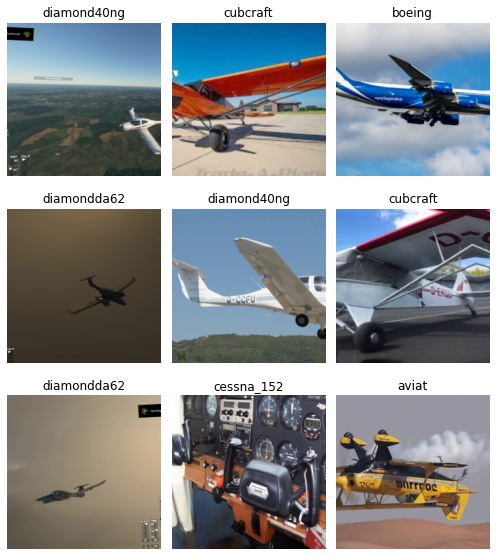

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['airbus',
  'aviat',
  'boeing',
  'cessna_152',
  'cessna_172',
  'cessna_208',
  'cessna_cj',
  'cubcraft',
  'daher',
  'diamond40ng',
  'diamondda62',
  'extra'],
 12,
 2880,
 720)

### Train model

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10)

NameError: ignored

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
for i in listdir("random_selection_test"):
  for j in listdir("random_selection_test" + "/" + i):
    correct_labels.append(i)
    img = open_image("random_selection_test/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Mixed accuracy: " + str(accuracy))


In [ ]:
predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused}).sort_values("correct")
predictions[predictions.correct != predictions.prediction]

## Adding image augmentation (creating separate folders)

### Wrap, mean, random hsv and rotation augmentation functions

In [ ]:
# Transformation functions
#img_raw = tf.io.read_file(input_folder + folder_name + filename)
      
def median_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      img = tf.image.convert_image_dtype(img, tf.dtypes.float32)
      #img = tf.image.resize(img, [500,500])
      mean = tfa.image.median_filter2d(img, filter_shape=5)
      return mean

def wrap_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
      init_flows = np.float32(np.random.normal(size=flow_shape) * 2.0)
      dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
      dense_img_warp = tf.squeeze(dense_img_warp, 0)
      return dense_img_warp

def random_hsv(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
    delta = 0.5
    lower_saturation = 0.1
    upper_saturation = 0.9
    lower_value = 0.2
    upper_value = 0.8
    delta = 0.5
#    saturation = 0.3
    value = 0.6
    #adj_hsvinyiq = tfa.image.adjust_hsv_in_yiq(img, delta, saturation, value)

    rand_hsvinyiq = tfa.image.random_hsv_in_yiq(img, delta, lower_saturation, upper_saturation, lower_value, upper_value)
    return rand_hsvinyiq
    #return adj_hsvinyiq

def rotate(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = img_raw
    img = tf.image.convert_image_dtype(img, tf.float32)
    rotated = tfa.image.rotate(img, tf.constant(np.pi/8))
    return rotated

#input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)



In [ ]:
pip install -q -U tensorflow-addons

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from PIL import Image

# With the entire training set and training after that:
# No resizing at this point

def image_folder_filter(input_folder, output_folder, method):
  
  input_folder = input_folder + "/"
  output_folder = output_folder + "/"
  folders = listdir(input_folder)
  if os.path.isdir(output_folder) == False:
    try: 
      os.mkdir(output_folder)
    except OSError:
      print("Creation of the directory '" + output_folder + "' failed")

  for folder_name in folders:
    folder_name = folder_name + "/"
    files_in_folder = listdir(input_folder + folder_name)

    if os.path.isdir(output_folder + folder_name) == False:
      try: 
        os.mkdir(output_folder + folder_name)
      except OSError:
        print("Creation of the directory '" + output_folder + folder_name + "' failed")

    for filename in files_in_folder:
      img_raw = tf.io.read_file(input_folder + folder_name + filename)
      if method == "median":
        transformed_result = median_transform(img_raw)
      elif method == "wrap":
        transformed_result = wrap_transform(img_raw)
      elif method == "random_hsv":
        transformed_result = random_hsv(img_raw)
      elif method == "rotate":
        transformed_result = rotate(img_raw)

      tf.keras.preprocessing.image.save_img( output_folder + folder_name + filename, transformed_result)


In [ ]:
from datetime import datetime

# Creating a folder for each augmentation - test and train separate
# In total it should take about 15 minutes

print(datetime.now(tz=None))

image_folder_filter("random_selection_train", "random_selection_train_mean", method = "median")
image_folder_filter("random_selection_train", "random_selection_train_mean", method = "median")
image_folder_filter("random_selection_test", "random_selection_test_mean", method = "median")
image_folder_filter("random_selection_train", "random_selection_train_wrap", method = "wrap")
image_folder_filter("random_selection_test", "random_selection_test_wrap", method = "wrap")
image_folder_filter("random_selection_train", "random_selection_train_random_hsv", method = "random_hsv")
image_folder_filter("random_selection_test", "random_selection_test_random_hsv", method = "random_hsv")
image_folder_filter("random_selection_train", "random_selection_train_rotate", method = "rotate")
image_folder_filter("random_selection_test", "random_selection_test_rotate", method = "rotate")

print(datetime.now(tz=None))


In [ ]:
# a visualization of what each filter looks like
test_read = tf.io.read_file("random_selection_train/airbus/" + os.listdir("random_selection_train/airbus/")[0])

images_list = [median_transform(test_read),
wrap_transform(test_read),
random_hsv(test_read),
rotate(test_read)]

veerge = 2
fig, axs = plt.subplots(2, veerge, figsize = (20, 15))
counter = -1

for row in axs:
  for col in row:
      counter = counter + 1
      col.imshow(images_list[counter]) 


In [ ]:
print(os.path.isdir("random_selection_train_mean"))
print(os.path.isdir("random_selection_test_mean"))

## Training and evaluating on augmented data 

### Mean augmentation (soft edges)

In [ ]:
train_directory = "random_selection_train_mean"
test_directory = "random_selection_test_mean"

path = Path(train_directory)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,2.411371,1.387126,0.567447,12:31
1,1.728031,1.130117,0.625418,12:33


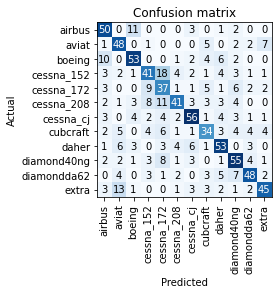

In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_mean = predictions

predictions[predictions.correct != predictions.prediction]


Mixed accuracy: 0.7294444444444445


###Wrap augmentation

In [ ]:
train_directory = "random_selection_train_wrap"
test_directory = "random_selection_test_wrap"

path = Path(train_directory)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_wrap = predictions

predictions[predictions.correct != predictions.prediction]


KeyboardInterrupt: ignored

### Random hsv augmentation

In [ ]:
train_directory = "random_selection_train_random_hsv"
test_directory = "random_selection_test_random_hsv"

path = Path(train_directory)


In [ ]:
#"random_selection_test_random_hsv"

epoch,train_loss,valid_loss,accuracy,time
0,2.588769,1.180113,0.620112,05:17
1,1.847051,1.089305,0.670391,05:15


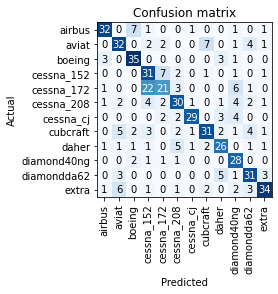

In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_random_hsv = predictions

predictions[predictions.correct != predictions.prediction]


Accuracy: 0.4722222222222222


,correct,prediction
1596,airbus,cessna_cj
1598,airbus,cessna_cj
1599,airbus,aviat
1593,airbus,diamond40ng
1603,airbus,diamond40ng
...,...,...
253,extra,aviat
251,extra,diamondda62
247,extra,daher
245,extra,aviat


### Rotation augmentation

In [ ]:
train_directory = "random_selection_train_rotate"
test_directory = "random_selection_test_rotate"

path = Path(train_directory)


epoch,train_loss,valid_loss,accuracy,time
0,2.934348,1.377386,0.554935,05:16
1,2.098109,1.222790,0.608939,05:15
2,1.714688,1.162051,0.636872,05:15


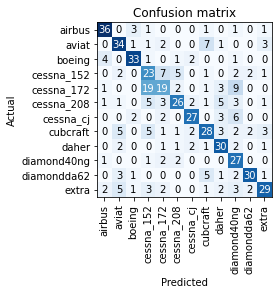

In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_rotation = predictions

predictions[predictions.correct != predictions.prediction]


Accuracy: 0.4888888888888889


,correct,prediction
1597,airbus,cessna_172
1598,airbus,cessna_cj
1599,airbus,diamond40ng
1593,airbus,cubcraft
1603,airbus,cessna_152
...,...,...
250,extra,cessna_152
249,extra,cessna_152
247,extra,cessna_172
245,extra,cessna_172


## Background eliminated data

In [ ]:
train_directory = "random_selection_augmented_jpg/random_selection_train"
test_directory = "random_selection_augmented_jpg/random_selection_test"

path = Path(train_directory)


In [ ]:
#len(complete_selection_test)/len(np.unique(predictions.prediction))
#import numpy as np
#np.unique(predictions.prediction)
complete_selection_test

array(['all_data_color/airbus_color/airbus_color_1463.jpg', 'all_data_color/airbus_color/airbus_color_438.jpg',
       'all_data_color/airbus_color/airbus_color_5274.jpg', 'all_data_color/airbus_color/airbus_color_118.jpg', ...,
       'msf_data/image_data_rainy/airbus_rainy99.jpg', 'msf_data/image_data_rainy/airbus_rainy100.jpg',
       'msf_data/image_data_rainy/airbus_rainy197.jpg', 'msf_data/image_data_rainy/airbus_rainy281.jpg'], dtype='<U49')

In [ ]:
len(complete_selection_train)

300

In [ ]:
  # Test and train ratio must be adjusted here (because in the folder its 40/60 but should be 20/80)
 # os.mkdir("random_selection_test/" +  nimede_vastavus.game_name[i])
 # for filename in complete_selection_test:
 #   shutil.copy(filename, "random_selection_test/" +  nimede_vastavus.game_name[i])

epoch,train_loss,valid_loss,accuracy,time
0,2.456149,1.299412,0.625698,05:14
1,1.791142,1.090293,0.659218,05:10


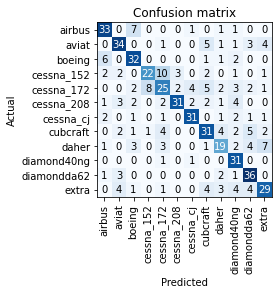

In [ ]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(10)

interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix()

In [ ]:
warnings.filterwarnings('ignore')

tulemused = []
correct_labels = []
image_locs = []

for i in listdir(test_directory):
  for j in listdir(test_directory + "/" + i):
    image_loc = test_directory + "/" + i +"/" + j
    image_locs.append(image_loc)
    correct_labels.append(i)
    img = open_image(test_directory + "/" + i +"/" + j)
    pred_class,pred_idx,outputs = learn.predict(img)
    vastus = data.classes[int(pred_class)]
    tulemused = np.append(tulemused, vastus)

accuracy = sum(tulemused == correct_labels)/len(correct_labels)

print("Accuracy: " + str(accuracy))

predictions = pd.DataFrame({"correct": correct_labels, "prediction": tulemused})
predictions_background = predictions

predictions[predictions.correct != predictions.prediction]


Accuracy: 0.5158421345191774


,correct,prediction
0,cessna_cj,diamond40ng
1,cessna_cj,cessna_172
2,cessna_cj,daher
5,cessna_cj,airbus
8,cessna_cj,airbus
...,...,...
1793,cubcraft,cessna_172
1795,cubcraft,cessna_172
1796,cubcraft,extra
1797,cubcraft,cessna_cj


## Visualizing misclassified examples (background elimination)

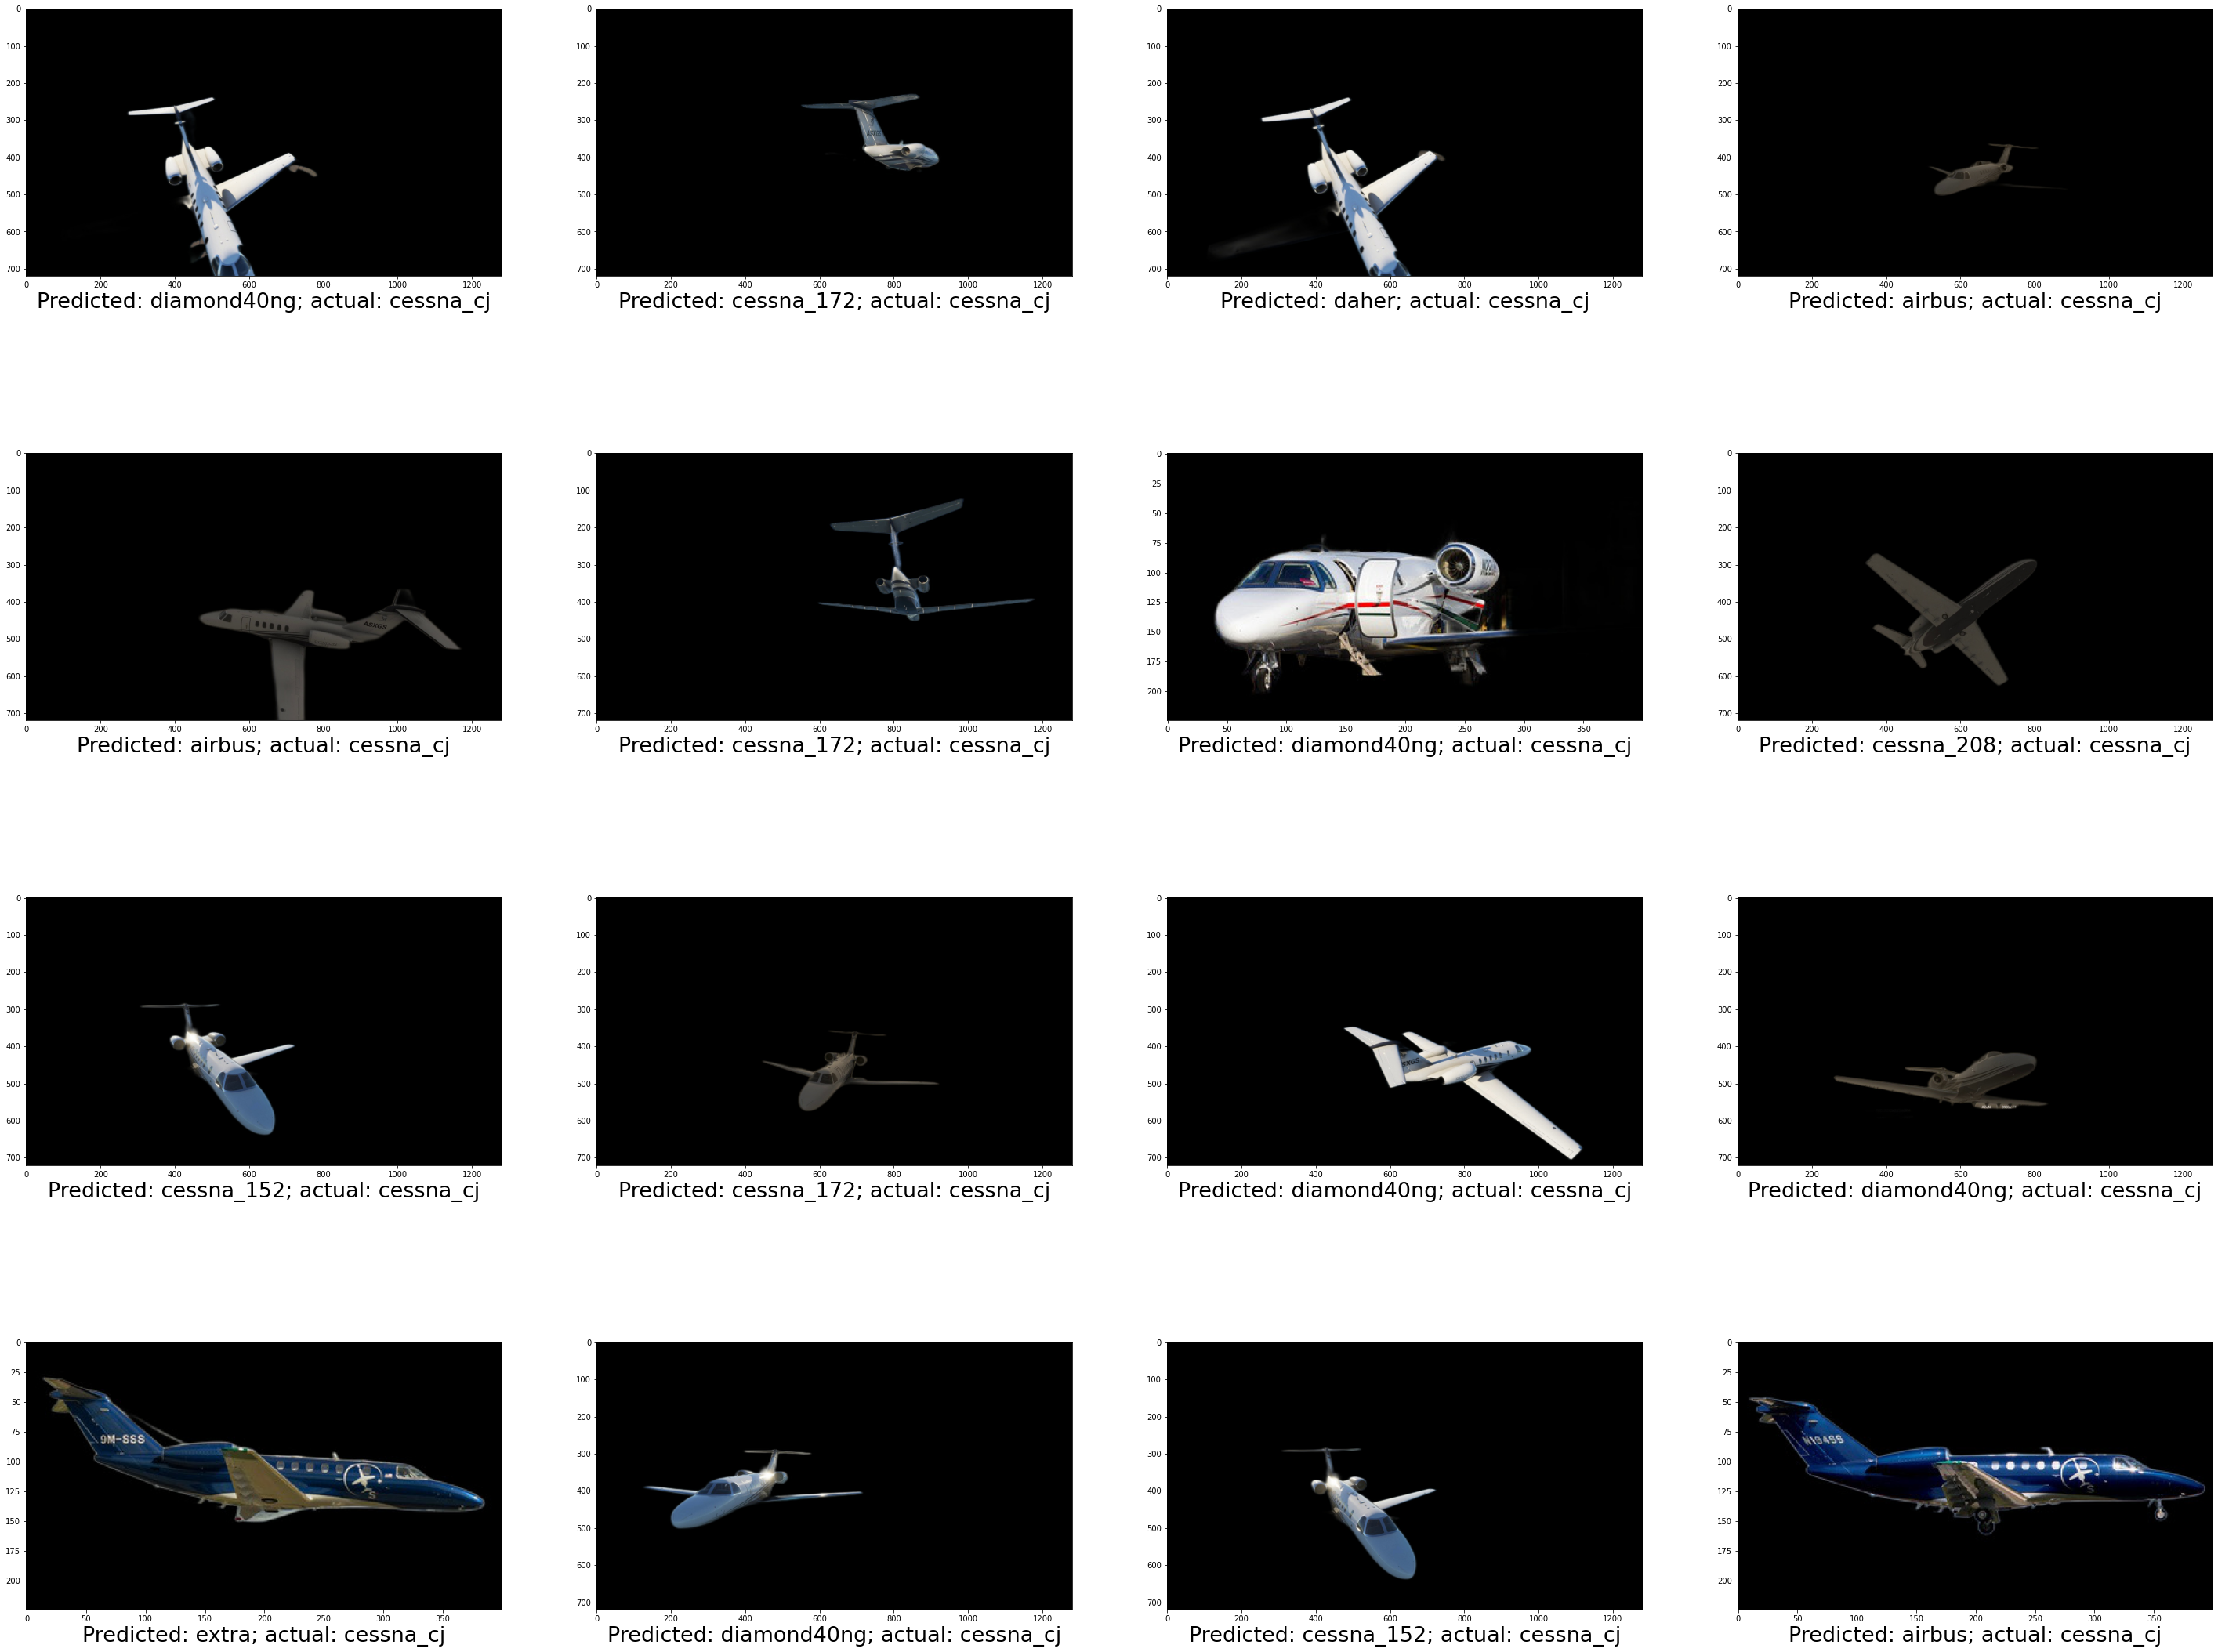

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from PIL import Image

veerge = 4
ridu = 4
fig, axs = plt.subplots(ridu, veerge, figsize = (50, 40))
counter = -1
predictions_wrong = predictions[predictions.correct != predictions.prediction]

for row in axs:
  for col in row:
      counter = counter + 1
      col.imshow(Image.open(np.array(image_locs)[tulemused != correct_labels][counter]))     
      col.set_xlabel("Predicted: " + predictions_wrong.iloc[counter,:].prediction + "; actual: " + predictions_wrong.iloc[counter,].correct)
      col.xaxis.label.set_size(27)

In [ ]:
image_locs_test = image_locs
image_locs_train = []
for i in listdir(train_directory):
  for j in listdir(train_directory + "/" + i):
    image_loc = train_directory + "/" + i +"/" + j
    image_locs_train.append(image_loc)

print(len(image_locs_test))
len(image_locs_train)

(len(image_locs_test))/((len(image_locs_test)) + len(image_locs_train))


1799


2688

0.40093603744149764

In [ ]:
from datetime import datetime

# current date and time
print(datetime.now())


In [ ]:

with open('/train_valik', 'w') as writefile:
   for i in complete_selection_train:
    writefile.write(i)

with open('/test_valik', 'w') as writefile:
   for i in complete_selection_test:
    writefile.write(i)

